In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy.interpolate import griddata
import warnings
from numpy import linalg as la

import torch as th
dtype = torch.float
# warnings.filterwarnings("ignore", category=RuntimeWarning)

**Calculation of invariants and tensor basis**

In [2]:
# load DNS data
data = np.loadtxt('tensor_data/Hill_Re2800_ASCII_Breuer.dat', skiprows=16)

In [3]:
# get shape of data
N, M = data.shape

In [4]:
# extract relevant data from dataset
RS_DNS = torch.tensor(np.array([data[:,6], data[:,9], np.full(N,0),
                                data[:,9], data[:,7], np.full(N,0),
                                np.full(N,0), np.full(N,0), data[:,8]]).T.reshape(-1,3,3))
cellCenters_DNS = torch.tensor([data[:,0],data[:,1]]).T
k0_DNS = torch.from_numpy(RS_DNS.numpy().trace(axis1 = 1, axis2 = 2))

# expand k
k_DNS = k0_DNS.unsqueeze(0).unsqueeze(0).expand(3,3,k0_DNS.size()[0])
k_DNS = k_DNS.permute(2, 0, 1)

# compute anisotropy tensor b
b = RS_DNS/(2*k_DNS) - 1/3 * torch.eye(3).unsqueeze(0).expand(k0_DNS.shape[0],3,3)

In [5]:
# read in RANS data + preprocessing
path = '/home/leonriccius/OpenFOAM_build/OpenFOAM-v2006/custom_cases/periodic_hills_RANS/refined_mesh/kEpsilon/5600/1500/'

# RS_RANS = torch.load(path + 'RS-torch.th')
R = torch.load(path + 'R-torch.th')
S = torch.load(path + 'S-torch.th')
k0 = torch.load(path + 'k-torch.th')
epsilon0 = torch.load(path + 'epsilon-torch.th')
cellCenters_RANS = torch.tensor(torch.load(path + 'cellCenters-torch.th')[:,0:2])

# expand k
k = k0.unsqueeze(0).unsqueeze(0).expand(3,3,k0.size()[0])
k = k.permute(2, 0, 1)

# expand epsilon
epsilon = epsilon0.unsqueeze(0).unsqueeze(0).expand(3,3,epsilon0.size()[0])
epsilon = epsilon.permute(2, 0, 1)

# normalize S and R
r_hat = k/epsilon*R
s_hat = k/epsilon*S

**Calculation of invariants and tensor basis from Geneva**

In [6]:
def getInvariants(s0, r0):
    """function for computation of tensor basis
        Inputs:
            s0: N x 3 x 3 (N is number of datapoints)
            r0: N x 3 x 3
        Outputs:
            invar_sig : N x 5 (5 is number of scalar invariants)
    """
    nCells = s0.size()[0]
    invar = th.zeros(nCells, 5).type(dtype)

    s2 = s0.bmm(s0)
    r2 = r0.bmm(r0)
    s3 = s2.bmm(s0)
    r2s = r2.bmm(s0)
    r2s2 = r2.bmm(s2)

    invar[:,0] = (s2[:,0,0]+s2[:,1,1]+s2[:,2,2]) #Tr(s2)
    invar[:,1] = (r2[:,0,0]+r2[:,1,1]+r2[:,2,2]) #Tr(r2)
    invar[:,2] = (s3[:,0,0]+s3[:,1,1]+s3[:,2,2]) #Tr(s3)
    invar[:,3] = (r2s[:,0,0]+r2s[:,1,1]+r2s[:,2,2]) #Tr(r2s)
    invar[:,4] = (r2s2[:,0,0]+r2s2[:,1,1]+r2s2[:,2,2]) #Tr(r2s2)

    # Scale invariants by sigmoid function
    # Can use other scalings here
    invar_sig = (1.0 - th.exp(-invar))/(1.0 + th.exp(-invar))
    invar_sig[invar_sig != invar_sig] = 0

    return invar_sig
    
def getTensorFunctions(s0, r0):
    """function for computation of tensor basis
        Inputs:
            s0: N x 3 x 3 (N is number of datapoints)
            r0: N x 3 x 3
        Outputs:
            T : N x 10 x 3 x 3 (10 is number of basis tensors)
    """
    
    nCells = s0.size()[0]
    T = th.zeros(nCells,10,3,3).type(dtype)

    s2 = s0.bmm(s0)
    r2 = r0.bmm(r0)
    sr = s0.bmm(r0)
    rs = r0.bmm(s0)

    T[:,0] = s0
    T[:,1] = sr - rs
    T[:,2] = s2 - (1.0/3.0)*th.eye(3).type(dtype)*(s2[:,0,0]+s2[:,1,1]+s2[:,2,2]).unsqueeze(1).unsqueeze(1)
    T[:,3] = r2 - (1.0/3.0)*th.eye(3).type(dtype)*(r2[:,0,0]+r2[:,1,1]+r2[:,2,2]).unsqueeze(1).unsqueeze(1)
    T[:,4] = r0.bmm(s2) - s2.bmm(r0)
    t0 = s0.bmm(r2)
    T[:,5] = r2.bmm(s0) + s0.bmm(r2) - (2.0/3.0)*th.eye(3).type(dtype)*(t0[:,0,0]+t0[:,1,1]+t0[:,2,2]).unsqueeze(1).unsqueeze(1)
    T[:,6] = rs.bmm(r2) - r2.bmm(sr)
    T[:,7] = sr.bmm(s2) - s2.bmm(rs)
    t0 = s2.bmm(r2)
    T[:,8] = r2.bmm(s2) + s2.bmm(r2) - (2.0/3.0)*th.eye(3).type(dtype)*(t0[:,0,0]+t0[:,1,1]+t0[:,2,2]).unsqueeze(1).unsqueeze(1)
    T[:,9] = r0.bmm(s2).bmm(r2) + r2.bmm(s2).bmm(r0)

    # Scale the tensor basis functions by the L2 norm
    l2_norm = th.zeros(T.size(0), 10)
    l2_norm = 0
    for (i, j), x in np.ndenumerate(np.zeros((3,3))):
        l2_norm += th.pow(T[:,:,i,j],2)
    T = T/th.sqrt(l2_norm).unsqueeze(2).unsqueeze(3)

    return T

In [7]:
# compute invariants
inv = getInvariants(s_hat, r_hat)
T = getTensorFunctions(s_hat, r_hat)

**Interpolation on grid first, computation of invariants and tensorbasis second**

In [8]:
# # interpolating on cartesian grid
# grid_x, grid_y = np.mgrid[3.:4.:100j, 1.:2.:100j]
# grid = [grid_x, grid_y]

# # interpolating DNS data (b)
# b_interp = torch.tensor(griddata(cellCenters_DNS_box, b_box, (grid_x, grid_y), method='linear')).flatten(end_dim = 1)

# # interpolating RANS data (r_hat, s_hat)
# r_hat_interp = torch.tensor(griddata(cellCenters_RANS_box, r_hat_box, (grid_x, grid_y), method='linear')).flatten(end_dim = 1)
# s_hat_interp = torch.tensor(griddata(cellCenters_RANS_box, s_hat_box, (grid_x, grid_y), method='linear')).flatten(end_dim = 1)

# # reshaping grid
# grid_interp = torch.tensor([grid_x.flatten(), grid_y.flatten()]).T

# # store all data needed for the NN
# torch.save(r_hat_interp, 'tensor_data/r_hat-torch.th')
# torch.save(s_hat_interp, 'tensor_data/s_hat-torch.th')
# torch.save(b_interp, 'tensor_data/b_DNS-torch.th')
# torch.save(grid_interp, 'tensor_data/grid-torch.th')

# fig, ax = plt.subplots()
# # ax.scatter(grid_interp[:,0], grid_interp[:,1])
# ax.contourf(grid_x, grid_y, griddata(cellCenters_RANS, s_hat, (grid_x, grid_y), method='linear')[:,:,0,0])

**Computation of invariants and tensorbasis first, interpolation on grid second**

In [9]:
# interpolating DNS data (b)
grid_x, grid_y = np.mgrid[3.:4.:30j, 1.:2.:30j]
grid = [grid_x, grid_y]
b_interp = torch.tensor(griddata(cellCenters_DNS, b, (grid_x, grid_y), method='linear')).flatten(end_dim = 1)

# interpolating invariants and tensor functions
inv_interp = torch.tensor(griddata(cellCenters_RANS, inv, (grid_x, grid_y), method='linear')).flatten(end_dim = 1)
T_interp = torch.tensor(griddata(cellCenters_RANS, T, (grid_x, grid_y), method='linear')).flatten(end_dim = 1)

# reshaping grid
grid_interp = torch.tensor([grid_x.flatten(), grid_y.flatten()]).T

#store tensor needed for NN
# torch.save(b_interp, 'tensor_data/post_interpolation/b_DNS-torch.th')
# torch.save(inv_interp, 'tensor_data/post_interpolation/inv-torch.th')
# torch.save(T_interp, 'tensor_data/post_interpolation/T-torch.th')
# torch.save(grid_interp, 'tensor_data/post_interpolation/grid-torch.th')

**Visualization of QoI**

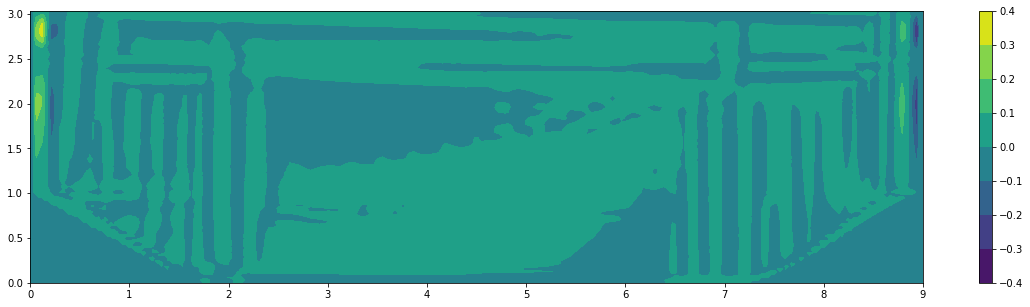

In [10]:
# making grid for domain
grid_all_x, grid_all_y = np.mgrid[0.:9.:300j, 0.:3.035:100j]
grid_all_z1 = griddata(cellCenters_RANS, inv[:,3], (grid_all_x, grid_all_y), method='linear')

# remove Nan data points under hill crest
mask_1 = np.isnan(grid_all_z1)
grid_all_z1[mask_1] = 0
# mask_2 = np.where(grid_all_z1<-0.45)
# grid_all_z1[mask_2] = -0.45
# mask_3 = np.where(grid_all_z1>-0.05)
# grid_all_z1[mask_3] = -0.05
fig, ax = plt.subplots(figsize=(20,5))
DNS_all_domain = ax.contourf(grid_all_x, grid_all_y, grid_all_z1[:,:])
fig.colorbar(DNS_all_domain, ax=ax)

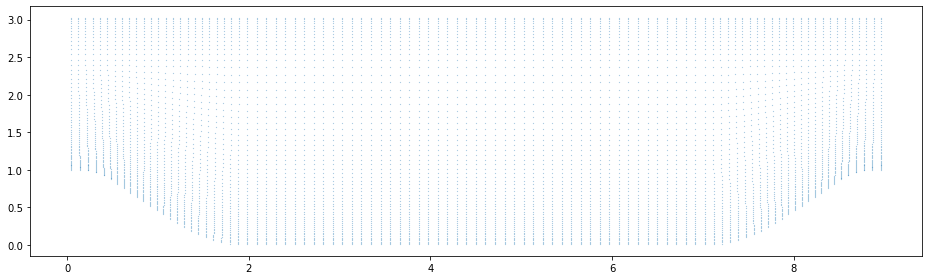

In [11]:
# plot datapoints of RANS
fig, ax = plt.subplots(figsize=(13,4), tight_layout=True)
ax.scatter(cellCenters_RANS[:,0], cellCenters_RANS[:,1], s=0.02)

In [12]:
fine_grid_x, fine_grid_y = np.mgrid[3.:4.:500j, 1.:2.:500j]

grid_z1 = b_interp[:,1,0].reshape(30,30)  # RS_DNS
grid_z2 = griddata(cellCenters_DNS_box, b_box[:,0,0], (fine_grid_x, fine_grid_y), method='linear')

NameError: name 'cellCenters_DNS_box' is not defined

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12,5))
DNS_griddata = ax[0].contourf(grid_x, grid_y, grid_z1)
DNS_box = ax[1].contourf(fine_grid_x, fine_grid_y, grid_z2)
fig.colorbar(DNS_griddata, ax=ax[0])
fig.colorbar(DNS_box, ax=ax[1])
# plt.title('interp2d')
ax[0].set_title('griddata')
ax[1].set_title('DNS')

**Older code snippets that might be needed later but are not in use now**

In [ ]:
# def bounding_box(x_lim, y_lim, cellCenters):
#     """function for creating a mask to select points within a bounding box"""
#     mask_x_min = np.where(cellCenters[:,0] > x_lim[0])
#     mask_x_max = np.where(cellCenters[mask_x_min,0].squeeze() < x_lim[1])
#     cellCenters_x = cellCenters[mask_x_min][mask_x_max]
    
#     mask_y_min = np.where(cellCenters_x[:,1] > y_lim[0])
#     mask_y_max = np.where(cellCenters_x[mask_y_min,1].squeeze() < y_lim[1])
#     return (mask_x_min, mask_x_max, mask_y_min, mask_y_max)

In [ ]:
# def select_from_mask(mask_list, array):
#     """function that selects the datapoints when given a list of masks
#     list must contain 4 masks created from bounding_box"""
#     return array[mask_list[0]][mask_list[1]][mask_list[2]][mask_list[3]]

In [ ]:
# # creating mask for data selection from RANS field
# mask_list = bounding_box([2.75,4.25],[0.75,2.25], cellCenters_RANS)

In [ ]:
# # selecting RANS data in bounding box
# cellCenters_RANS_box = select_from_mask(mask_list, cellCenters_RANS)
# r_hat_box = select_from_mask(mask_list, r_hat)
# s_hat_box = select_from_mask(mask_list, s_hat)

In [ ]:
# # creating mask for data selection from DNS field
# mask_list_DNS = bounding_box([2.75, 4.25], [0.75, 2.25], cellCenters_DNS)

# # selecting DNS data in bounding box
# cellCenters_DNS_box = select_from_mask(mask_list_DNS, cellCenters_DNS)
# RS_DNS_box = select_from_mask(mask_list_DNS, RS_DNS)
# b_box = select_from_mask(mask_list_DNS, b)
# cellCenters_DNS_box.shape